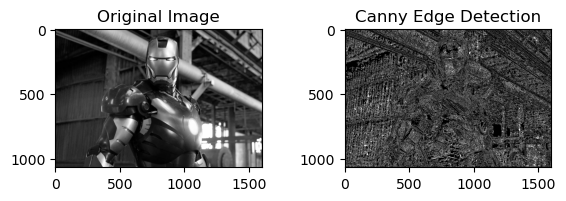

In [3]:
#Edge Detection using Canny Edge Detector
import numpy as np
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import os

class gaussian:
    def __init__(self, window_size, sigma):
        if window_size % 2 == 0:
            raise ValueError("Window size must be odd.")

        # center of the kernel
        center = window_size // 2

        # Generating 1D Gaussian kernel
        self.kernel_1d = np.array([np.exp(-(i - center)**2 / (2 * sigma**2)) for i in range(window_size)])

        # Normalize the 1D kernel
        self.kernel_1d /= np.sum(self.kernel_1d)

    def kernel(self, window_size):
        kernel_2d = np.zeros((window_size, window_size))
        for i in range(window_size):
            for j in range(window_size):
                kernel_2d[i, j] = self.kernel_1d[i] * self.kernel_1d[j]
        return kernel_2d
    
class convolution:
    def __init__(self, image, kernel):
        self.m, self.n = image.shape
        self.k_m, self.k_n = kernel.shape
        self.result = np.zeros_like(image)
        self.image = image
        self.kernel = kernel
        
    def conv(self):
        for i in range(self.m - self.k_m + 1):
            for j in range(self.n - self.k_n + 1):
                self.result[i, j] = np.sum(self.image[i:i+self.k_m, j:j+self.k_n] * self.kernel)
        return self.result
    
    
###########################################################################################################################
    
class canny_edge_detection:
    def __init__(self, loc, output_dir, low_thres_ratio, high_thres_ratio):
        #input image
        img = cv2.imread(loc, cv2.IMREAD_GRAYSCALE)
        #creating gaussian kernel
        kernel = gaussian(window_size = 3, sigma = 1).kernel(window_size = 3)
        #Filtering the image with gaussian kernel
        self.img = convolution(image = img, kernel = kernel).conv()
        
        # Sobel kernel filtering to have the magnitude and angle
        Ix = convolution(image = self.img, kernel = self.kernel_sobel_horizontal()).conv()
        Iy = convolution(image = self.img, kernel = self.kernel_sobel_vertical()).conv()
        G = np.hypot(Ix, Iy)  #finding the euclidian norm to get the magnitude of the edge
        G = G/(G.max()) * 255
        angle = np.arctan2(Iy, Ix)
        
        #non_maximum_supression
        self.c = self.non_max_suppression(img = G, D = angle)
        
        #Thresholding
        image, weak, strong = self.threshold(img = self.c, lowThresholdRatio = low_thres_ratio, highThresholdRatio = high_thres_ratio)
        
        #Edge tracking through hysteresis
        y = self.hysteresis(image = image, weak = weak, strong = strong)

        # save the result
        output_dir =r'C:\Users\Tanjib Ahmed\Desktop\images'
        output_path = os.path.join(output_dir, 'edge_detection_canny.png')
        cv2.imwrite(output_path, y)
        
        #showing the result
        plt.subplot(121), plt.imshow(img, cmap = 'gray'), plt.title('Original Image')
        plt.subplot(122), plt.imshow(y, cmap = 'gray'), plt.title('Canny Edge Detection')
        plt.subplots_adjust(wspace=0.4)
    def non_max_suppression(self, img, D):
        M, N = self.img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi  #convert to degree
        angle[angle < 0] += 180

        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0

                except IndexError as e:
                    pass

        return Z
    
    def threshold(self, img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
        highThreshold = img.max() * highThresholdRatio;
        lowThreshold = highThreshold * lowThresholdRatio;################################??????

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(25)   #weak intesity value is 25
        strong = np.int32(255)  #strong intensity value is 255

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)
        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak
        return (res, weak, strong)
    
    def hysteresis(self, image, weak, strong):
        M, N = image.shape  
        for i in range(1, M-1):
            for j in range(1, N-1):
                if (image[i,j] == weak):
                    try:
                        if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                            or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                            or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                            image[i, j] = strong
                        else:
                            image[i, j] = 0
                    except IndexError as e:
                        pass
        return image

    def kernel_sobel_horizontal(self):
        H = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]

        ], dtype=np.float32)
        return H
    def kernel_sobel_vertical(self):
        H = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]

        ], dtype=np.float32)
        return H

loc = r'im3.webp'
output_dir =r'C:\Users\Tanjib Ahmed\Desktop\images'
canny_edge_detection(loc = loc, output_dir = output_dir, low_thres_ratio = 0.05, high_thres_ratio = 0.09)
